### Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report

import nltk
from nltk.corpus import stopwords

import tensorflow as tf

### Data Loading

In [2]:
df = pd.read_csv(os.path.join('datasets/jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

df.head()

,id,comment_text,Toxic,Severe Toxic,Obscene,Threat,Insult,Identity Hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Exploratory Data Analysis

In [3]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JOY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df_toxic = df.drop(['id', 'comment_text'], axis=1)
counts = []
categories = list(df_toxic.columns.values)

for i in categories:
    counts.append((i, df_toxic[i].sum()))

### Number of comments by categories

In [5]:
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,Toxic,15294
1,Severe Toxic,1595
2,Obscene,8449
3,Threat,478
4,Insult,7877
5,Identity Hate,1405


### Ploting Number of Ocurrence vs Categories

Text(0.5, 0, 'categories')

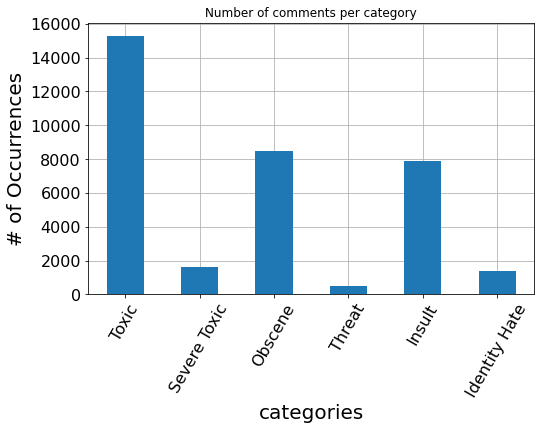

In [6]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, figsize=(8, 5), zorder=3)
plt.grid(zorder=0)
plt.xticks(fontsize=16, rotation=60)
plt.yticks(fontsize=16)
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=20)
plt.xlabel('categories', fontsize=20)

### Multiple Categories Per Comment

J:\Program Files\Anaconda3\envs\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, '# of categories')

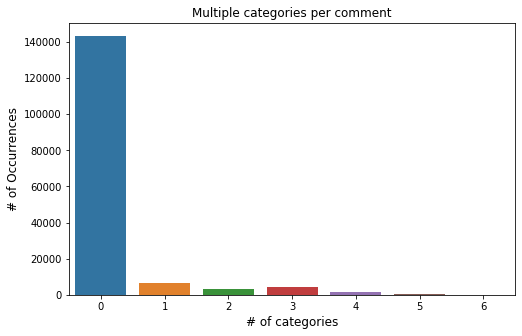

In [7]:
rowsums = df.iloc[:,2:].sum(axis=1)
x = rowsums.value_counts()

plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

### Not labeled Comments

In [8]:
print('Percentage of comments that are not labeled:')
print(len(df[(df['Toxic']==0) & (df['Severe Toxic']==0) & (df['Obscene']==0) & (df['Threat']== 0) & (df['Insult']==0) & (df['Identity Hate']==0)]) / len(df))

Percentage of comments that are not labeled:
0.8983211235124177


### Length of comments

<AxesSubplot:>

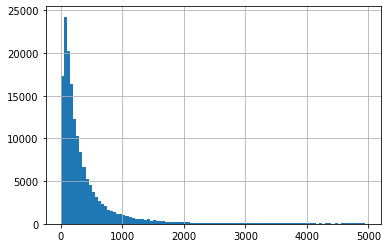

In [9]:
lens = df.comment_text.str.len()
lens.hist(bins = np.arange(0,5000,50))

### Missing Comments

In [10]:
print('Number of missing comments in comment text:')
df['comment_text'].isnull().sum()

Number of missing comments in comment text:


0

### Data Pre-Processing

In [11]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

### Train Test Split

In [12]:
df['comment_text'] = df['comment_text'].map(lambda com : clean_text(com))
df['comment_text'][0]

df = df.drop(['id'], axis=1)

categories = ['Toxic', 'Severe Toxic', 'Obscene', 'Threat', 'Insult', 'Identity Hate']
train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)

X_train = train.comment_text
X_test = test.comment_text
Y_train = train.loc[:, df.columns != 'comment_text']
Y_test = test.loc[:, df.columns != 'comment_text']

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(106912,)
(52659,)
(106912, 6)
(52659, 6)


### Naive Bayes Classifier

In [13]:
NB_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words=stop_words)),
                        ('clf', OneVsRestClassifier(MultinomialNB(
                        fit_prior=True, class_prior=None))),])

NB_pipeline.fit(X_train, Y_train)

prediction = NB_pipeline.predict(X_test)

print('Test accuracy is {}'.format(accuracy_score(Y_test, prediction)))

print(metrics.confusion_matrix(Y_test.values.argmax(axis=1), prediction.argmax(axis=1)))

print(metrics.classification_report(Y_test, prediction, target_names=categories))  

Test accuracy is 0.8986118232400919
[[52346     0     0     0     0]
 [  174     0     0     0     0]
 [    6     0     0     0     0]
 [  117     0     0     0     0]
 [   16     0     0     0     0]]
               precision    recall  f1-score   support

        Toxic       0.99      0.17      0.28      5083
 Severe Toxic       0.00      0.00      0.00       526
      Obscene       0.99      0.10      0.18      2831
       Threat       1.00      0.01      0.01       152
       Insult       0.98      0.04      0.08      2643
Identity Hate       0.00      0.00      0.00       471

    micro avg       0.99      0.11      0.19     11706
    macro avg       0.66      0.05      0.09     11706
 weighted avg       0.90      0.11      0.19     11706
  samples avg       0.02      0.01      0.01     11706



J:\Program Files\Anaconda3\envs\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
J:\Program Files\Anaconda3\envs\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Logistic Regression

In [14]:
LogReg_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words=stop_words)),
                            ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),])

LogReg_pipeline.fit(X_train, Y_train)

prediction = LogReg_pipeline.predict(X_test)

print('Test accuracy is {}'.format(accuracy_score(Y_test, prediction)))

print(metrics.confusion_matrix(Y_test.values.argmax(axis=1), prediction.argmax(axis=1)))

print(metrics.classification_report(Y_test, prediction, target_names=categories))

Test accuracy is 0.9181336523671167
[[52342     3     0     0     1]
 [  173     1     0     0     0]
 [    6     0     0     0     0]
 [  117     0     0     0     0]
 [   16     0     0     0     0]]
               precision    recall  f1-score   support

        Toxic       0.93      0.58      0.71      5083
 Severe Toxic       0.63      0.26      0.36       526
      Obscene       0.93      0.60      0.73      2831
       Threat       0.71      0.14      0.24       152
       Insult       0.82      0.48      0.61      2643
Identity Hate       0.69      0.14      0.24       471

    micro avg       0.89      0.52      0.66     11706
    macro avg       0.78      0.37      0.48     11706
 weighted avg       0.88      0.52      0.65     11706
  samples avg       0.05      0.04      0.05     11706



J:\Program Files\Anaconda3\envs\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
J:\Program Files\Anaconda3\envs\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Support Vector Classifier

In [15]:
SVC_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words=stop_words)),
                         ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),])

SVC_pipeline.fit(X_train, Y_train)

prediction = SVC_pipeline.predict(X_test)

print('Test accuracy is {}'.format(accuracy_score(Y_test, prediction)))

print(metrics.confusion_matrix(Y_test.values.argmax(axis=1), prediction.argmax(axis=1)))

print(metrics.classification_report(Y_test, prediction, target_names=categories))

Test accuracy is 0.9197478113902656
[[52286     1    31     0    22     6]
 [    0     0     0     0     0     0]
 [  171     0     2     0     1     0]
 [    6     0     0     0     0     0]
 [  115     0     1     0     1     0]
 [   15     0     0     0     0     1]]
               precision    recall  f1-score   support

        Toxic       0.87      0.68      0.77      5083
 Severe Toxic       0.56      0.28      0.38       526
      Obscene       0.89      0.70      0.78      2831
       Threat       0.65      0.26      0.37       152
       Insult       0.80      0.58      0.67      2643
Identity Hate       0.64      0.24      0.35       471

    micro avg       0.84      0.62      0.72     11706
    macro avg       0.73      0.46      0.55     11706
 weighted avg       0.83      0.62      0.71     11706
  samples avg       0.06      0.06      0.06     11706



J:\Program Files\Anaconda3\envs\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
J:\Program Files\Anaconda3\envs\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
